In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate, RZGate
from qiskit.quantum_info import Clifford, PauliList

In [ ]:
def random_thetas(shape: tuple[int]):
    possible_theta_values = np.pi / 2 * np.arange(4)
    return np.random.choice(possible_theta_values, shape)

def sum_Z(n_qubits: int) -> PauliList:
    def char(i,j): return 'Z' if i == j else 'I'
    return PauliList([
        ''.join([char(i,n_qubits - j - 1) for i in range(n_qubits)])
        for j in range(n_qubits)
    ])

In [ ]:
class ParametricCliffordCircuit:
    def __init__(self, n_qubits: int, thetas: np.ndarray):
        self.n_qubits = n_qubits
        self.thetas = thetas
        self.param_gate_label: int = 0
        self.label_index_dict: dict[str, int] = {}

        self.qc = QuantumCircuit(n_qubits)
        self._build_circuit()
    
    def _build_circuit(self) -> None:
        pass

    def _add_param_gate(self, gate_name: str, *args) -> None:
        getattr(self.qc, gate_name)(*args, label = str(self.param_gate_label))
        self.label_index_dict[str(self.param_gate_label)] = len(self.qc.data) - 1
        self.param_gate_label += 1
    
    @property
    def clifford_list(self) -> list[Clifford]:
        out: list[Clifford] = []
        gate = QuantumCircuit(self.n_qubits)
        for i in range(len(self.qc.data)):
            gate.data = [self.qc.data[i]]
            out.append(Clifford(gate))
        return out
    
    def get_labeled_gate(self, label: int | str, shift: float = 0) -> QuantumCircuit:
        index = self.label_index_dict[str(label)]
        old_instr = self.qc.data[index]

        if old_instr.operation.name == "rx":
            new_operation = RXGate(old_instr.params[0] + shift)
        if old_instr.operation.name == "rz":
            new_operation = RZGate(old_instr.params[0] + shift)

        out = QuantumCircuit(self.n_qubits)
        out.append(new_operation, old_instr.qubits, old_instr.clbits)
        return out
    
    def get_labeled_clifford(self, label: int | str, shift: float = 0) -> Clifford:
        return Clifford(
            self.get_labeled_gate(label, shift)
        )

    @property
    def n_gates(self): return len(self.qc.data)

    @property
    def n_parameters(self): return np.prod(self.thetas.shape)


class TestCircuit(ParametricCliffordCircuit):
    # def __init__(self, n_qubits, thetas):
    #     super().__init__(n_qubits, thetas)
    
    def _build_circuit(self) -> None:
        for i in range(self.n_qubits):
            self._add_param_gate("rx", self.thetas[i], i)


class ConvolutionalQNN(ParametricCliffordCircuit):
    def __init__(self, n_qubits: int, n_layers: int, thetas: np.ndarray):
        self.n_layers = n_layers
        super().__init__(n_qubits, thetas)
    
    def _two_qubit_gate(self, thetas: np.ndarray, qubit1: int, qubit2: int) -> None:
        self._add_param_gate("rx", thetas[0], qubit1)
        self._add_param_gate("rx", thetas[1], qubit2)
        self.qc.cx(qubit1, qubit2)
        self._add_param_gate("rz", thetas[2], qubit1)
        self._add_param_gate("rz", thetas[3], qubit2)
    
    def _layer(self, thetas: np.ndarray) -> None:
        i: int = 0  # Current column of used thetas
        def gate(q1: int, q2: int) -> None:
            "Applies the elementary _two_qubit_gate sweeping through thetas' columns"
            nonlocal i
            self._two_qubit_gate(thetas[:,i], q1, q2)
            i += 1
        
        def contiguous_qubits_gates(q: int) -> None:
            '''
            Args:
                q (int): Smallest qubit the bundle of gates is applied to. \\
                         e.g. contiguous_qubits_gates(2) applies to (2,3), (4,5), and (6,7)
            '''
            if q >= 0:
                gate(q, q+1)
            gate(q+2, q+3)
            if q + 5 <= self.n_qubits - 1:
                gate(q+4, q+5)

        def alternate_qubits_gates(q: int) -> None:
            gate(q, q + 2)
            gate(q + 1, q + 3)
        
        contiguous_qubits_gates(-2)
        for q in np.arange(0, self.n_qubits-2, 2):
            alternate_qubits_gates(q)
            contiguous_qubits_gates(q)

    def _build_circuit(self):
        reshaped_thetas = self.thetas.reshape(
            (4, 5 * self.n_qubits // 2 - 4, self.n_layers)
            )
        for i in range(self.n_layers):
            self._layer(reshaped_thetas[:,:,i])
            self.qc.barrier()


class CliffordList:
    def __init__(self, param_circ: ParametricCliffordCircuit):
        self.list: list[Clifford] = param_circ.clifford_list
        self.n_qubits: int = param_circ.n_qubits
        self.I: Clifford = Clifford.from_label("I" * param_circ.n_qubits)

        self.heads = self.build_heads()
        self.tails = self.build_tails()
    
    def build_heads(self) -> list[Clifford]:
        out = []
        op = self.I
        for gate in self.list:
            op = op.compose(gate)
            out.append(op)
        return out
    
    def build_tails(self) -> list[Clifford]:
        out = []
        op = self.I
        for gate in reversed(self.list):
            op = op.compose(gate, front = True)
            out.append(op)
        out.reverse()
        return out

class EvolvedPaulis:
    def __init__(self, op: PauliList, param_circ: ParametricCliffordCircuit):
        self.param_circ: ParametricCliffordCircuit = param_circ
        self.label_index_dict = self.param_circ.label_index_dict
        self.op: PauliList = op
        self.cliff_list: CliffordList = CliffordList(self.param_circ)

        self.plus_ops: dict[str, PauliList] = {}
        self.minus_ops: dict[str, PauliList] = {}
        self.evolve_op()
    
    def evolve_op(self) -> None:
        I = self.cliff_list.I
        shift = np.pi / 2
        for label, index in self.label_index_dict.items():
            head = self.cliff_list.heads[index - 1] if index > 0 else I
            gate_plus = self.param_circ.get_labeled_clifford(label, shift)
            gate_minus =  self.param_circ.get_labeled_clifford(label, -shift)
            tail = self.cliff_list.tails[index + 1] if index < self.param_circ.n_gates-1 else I

            clifford_plus = head.compose(gate_plus.compose(tail))
            clifford_minus = head.compose(gate_minus.compose(tail))

            self.plus_ops[label] = self.op.evolve(clifford_plus)
            self.minus_ops[label] = self.op.evolve(clifford_minus)



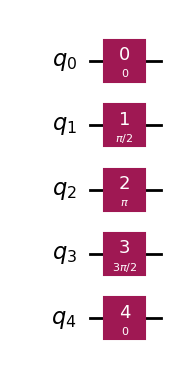

plus_ops = 



{'0': PauliList(['IIIIY', 'IIIYI', '-IIZII', '-IYIII', 'ZIIII']),
 '1': PauliList(['IIIIZ', '-IIIZI', '-IIZII', '-IYIII', 'ZIIII']),
 '2': PauliList(['IIIIZ', 'IIIYI', '-IIYII', '-IYIII', 'ZIIII']),
 '3': PauliList(['IIIIZ', 'IIIYI', '-IIZII', 'IZIII', 'ZIIII']),
 '4': PauliList(['IIIIZ', 'IIIYI', '-IIZII', '-IYIII', 'YIIII'])}

minus_ops = 



{'0': PauliList(['-IIIIY', 'IIIYI', '-IIZII', '-IYIII', 'ZIIII']),
 '1': PauliList(['IIIIZ', 'IIIZI', '-IIZII', '-IYIII', 'ZIIII']),
 '2': PauliList(['IIIIZ', 'IIIYI', 'IIYII', '-IYIII', 'ZIIII']),
 '3': PauliList(['IIIIZ', 'IIIYI', '-IIZII', '-IZIII', 'ZIIII']),
 '4': PauliList(['IIIIZ', 'IIIYI', '-IIZII', '-IYIII', '-YIIII'])}

In [4]:
"""
Test on a simple test circuit.
Using that RX(pi/2)^dag Z RX(pi/2) = Y,
we have:
 Z_0 -> +Y_0 if gate 0 is +shifted, -Y_0 if gate 0 is -shifted, else Z_0
 Z_1 -> -Z_1 if gate 1 is +shifted, +Z_1 if gate 1 is -shifted, else Y_1
 ...
"""

n_q: int = 5
thetas = np.pi / 2 * np.array([0, 1, 2, 3, 0])
param_circ = TestCircuit(n_q, thetas)

display(param_circ.qc.draw("mpl"))

op = sum_Z(n_q)
evolved_paulis = EvolvedPaulis(op, param_circ)
print("plus_ops = \n")
display(evolved_paulis.plus_ops)
print("minus_ops = \n")
display(evolved_paulis.minus_ops)


In [5]:
n_q = 10
n_l = 3
thetas = random_thetas(4 * 21 * 3)
param_circ = ConvolutionalQNN(n_q, n_l, thetas)
# param_circ.qc.draw("mpl")
op = sum_Z(n_q)
evolved_paulis = EvolvedPaulis(op, param_circ)

In [7]:
evolved_paulis.plus_ops

{'0': PauliList(['-IIIIIXIYXZ', '-IIIIXXZIIZ', '-XIXXIYZIIY', '-XIZYYXZIYX',
            'ZXXYIYYZXZ', '-YZIZZZIZXZ', '-ZZXXYYIZXZ', 'YZYYIXIIII',
            '-YIXIIZYZXZ', 'ZYYXXZYZII']),
 '1': PauliList(['IIIIIXIYXY', 'IIIIXXZIIY', '-XIXXIYZIIZ', 'XIZYYXZIZX',
            '-ZXXYIYYZXY', 'YZIZZZIZXY', 'ZZXXYYIZXY', 'YZYYIXIIII',
            'YIXIIZYZXY', 'ZYYXXZYZII']),
 '2': PauliList(['IIIIIXIYXX', 'IIIIXXZIIX', '-XIXXIYZIIZ', 'XIZYYXZIYY',
            '-ZXXYIYYZXX', 'YZIZZZIZXX', 'ZZXXYYIZXX', 'YZYYIXIIII',
            'YIXIIZYZXX', 'ZYYXXZYZII']),
 '3': PauliList(['IIIIIXIYXY', '-IIIIXXZIYX', '-XIXXIYZIIZ', '-XIZYYXZIIY',
            '-ZXXYIYYZXY', 'YZIZZZIZXY', 'ZZXXYYIZXY', 'YZYYIXIIII',
            'YIXIIZYZXY', 'ZYYXXZYZII']),
 '4': PauliList(['-IIIIIXIZXY', 'IIIIXXZIIY', '-XIXXIYZIIZ', '-XIZYYXZIYX',
            '-ZXXYIYYYXY', 'YZIZZZIYXY', 'ZZXXYYIYXY', 'YZYYIXIIII',
            'YIXIIZYYXY', 'ZYYXXZYYII']),
 '5': PauliList(['IIIIIXIYXY', 'IIIIXXYIIY', '-XIXXIYYIIZ', '-XIZY

In [ ]:
pl = evolved_paulis.plus_ops["0"]
single_pauli = pl[4]
print(str(single_pauli))
print(single_pauli.x)
print(single_pauli.z)
print(single_pauli._count_y)
print(single_pauli.phase)

ZXXYIYYZXZ
[False  True False  True  True False  True  True  True False]
[ True False  True  True  True False  True False False  True]
0


In [40]:
single_pauli.x | single_pauli.z

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True])

In [ ]:
from numba import njit

@njit
def fast_kernel(
    indices, vector, n_indices,
    z_mask, x_mask, count_y, phase
):
    